In [1]:
from collections import defaultdict
from math import log

tf1 = lambda t: 1
tf2 = lambda _struct: _struct[1]
tf3 = lambda t:0
tf4 = lambda _struct, t: log(1 + _struct[1])
tf6 = lambda tf, maxtf, a:a+(1-a)*(tf/maxtf)
tf5 = lambda tf, maxtf: tf6(tf, maxtf, 0.5)
idf1 = lambda df, N:log(N/df)
idf2 = lambda df, N:log(N/(1+df))
idf3 = lambda df, N:log((1 + N-df)/df)

In [2]:
_Collections = [
    ["A", "A", "A",  "A", "A"],
    ["A", "A", "A",  "A", "B"],
    ["A", "A", "A",  "A", "C"],
]

_Vocabulary = list()
_Lexicon = defaultdict(lambda: -1)
_Document = defaultdict(int)
_Posting = list()

for d in _Collections:
    _localPosting = defaultdict(int)
    for t in d:
        if t not in _Vocabulary:
            _Vocabulary.append(t)
        _localPosting[t] += 1
    docID = len(_Document)
    _Document[docID] = max(_localPosting.values())
    for t, f in _localPosting.items():
        ptr = _Lexicon[t]
        nextPtr = len(_Posting)
        _Posting.append((docID, f, ptr))
        _Lexicon[t] = nextPtr

# Euclidean distance

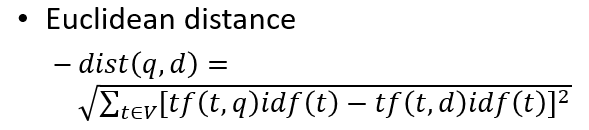

문제: summation을 할때, vocabulary에 속하는 모든 t(단어)에 대해서 실행하는데 t는 query에 없는 단어일수도 있다. 이때 penalty가 발생한다.



In [6]:
distance = lambda x1, x2: (x2- x1)**2

In [7]:
N = len(_Collections)
_Weight = list()
_WLexicon = defaultdict(lambda:{"Posting":None, "DF":0})
_DocLength = defaultdict(float)
for t, ptr in _Lexicon.items():
    dfPtr = ptr
    df = 0
    while dfPtr != -1:
        _struct = _Posting[dfPtr]
        df += 1
        dfPtr = _struct[-1]
    
    wptr = len(_Weight)
    while ptr != -1:
        _struct = _Posting[ptr]
        tf = _struct[1]
        maxtf = _Document[_struct[0]]
        w = tf6(tf, maxtf, 0)* idf2(df, N)
        print("단어:{0}, 문서:{1}, 빈도:{2}, 최고빈도:{3}, 가중치={4:.2f}"
              .format(
                  t, _struct[0], _struct[1],
                  maxtf, w))
        
        ptr = _struct[-1]
        
        wStruct = (_struct[0], w)
        _Weight.append(wStruct)
        _DocLength[_struct[0]] += distance(0, w)
    _WLexicon[t]["Posting"] = wptr
    _WLexicon[t]["DF"] = df

단어:A, 문서:2, 빈도:4, 최고빈도:4, 가중치=-0.29
단어:A, 문서:1, 빈도:4, 최고빈도:4, 가중치=-0.29
단어:A, 문서:0, 빈도:5, 최고빈도:5, 가중치=-0.29
단어:B, 문서:1, 빈도:1, 최고빈도:4, 가중치=0.10
단어:C, 문서:2, 빈도:1, 최고빈도:4, 가중치=0.10


In [8]:
from math import sqrt

Q = "B B B"
result = defaultdict(float)
QueryRepr = defaultdict(int)
QueryWeight = defaultdict(float)
for t in Q.split():
    if t in _Vocabulary:
        QueryRepr[t] += 1
maxQuery = max(QueryRepr.values())
for t, f in QueryRepr.items():
    w = tf6(f, maxQuery, 0)*idf1(_WLexicon[t]["DF"], N)
    QueryWeight[t] = w

for t in _Vocabulary:
    ptr = _WLexicon[t]["Posting"]
    df = _WLexicon[t]["DF"]
    for _struct in _Weight[ptr:ptr+df]:
        _struct[0] # => 문서
        _struct[1] # => 가중치
        result[_struct[0]] = distance(QueryWeight[t],
                                      _struct[1])
    
result = {d:sqrt(dist)  for d, dist in result.items()}

In [9]:
result

{2: 0.1013662770270411, 1: 0.9972460116410686, 0: 0.2876820724517809}

>\* 용어
>
>concept = controlled words

In [10]:
# 여기 안되지 왜?!

Q = "A A A A B"
result = defaultdict(float)
QueryRepr = defaultdict(int)
QueryWeight = defaultdict(float)
QueryLength = 0.0
for t in Q.split():
    if t in _Vocabulary:
        QueryRepr[t] += 1
maxQuery = max(QueryRepr.values())
for t, f in QueryRepr.items():
    w = tf6(f, maxQuery, 0)*idf2(_WLexicon[t]["DF"], N)
    QueryWeight[t]= w
    QueryLength += distance(0,w)

for t in QueryRepr:
    ptr = _WLexicon[t]["Posting"]
    df = _WLexicon[t]["DF"]
    for _struct in _Weight[ptr:ptr+df]:
        _struct[0] # => 문서
        _struct[1] # => 가중치
        result[_struct[0]] += QueryWeight[t] * _struct[1]    
result = {d:ip/(sqrt(QueryLength)*sqrt(_DocLength[d]))
          for d, ip in result.items()}

In [11]:
_DocLength

defaultdict(float,
            {2: 0.09303609692847455,
             1: 0.09303609692847455,
             0: 0.08276097481015171})

In [12]:
result

{2: 0.889557682904279, 1: 1.0000000000000002, 0: 0.9431636564797644}

---

In [14]:
# Posting File
from struct import pack, unpack

_Collections = [
    ["A", "A", "A",  "A", "A"],
    ["A", "A", "A",  "A", "B"],
    ["A", "A", "A",  "A", "C"],
]

_Vocabulary = list()
_Lexicon = defaultdict(lambda: -1)
_Document = defaultdict(int)
_Posting = list()

fp = open("posting.dat", "wb")

for d in _Collections:
    _localPosting = defaultdict(int)
    for t in d:
        if t not in _Vocabulary:
            _Vocabulary.append(t)
        _localPosting[t] += 1
    docID = len(_Document)
    _Document[docID] = max(_localPosting.values())
    for t, f in _localPosting.items():
        ptr = _Lexicon[t]
#         nextPtr = len(_Posting)
#         _Posting.append((docID, f, ptr))
        nextPtr = fp.tell()
        fp.write(pack("iii", docID, f, ptr))
        _Lexicon[t] = nextPtr
        
fp.close()

In [15]:
N = len(_Collections)
_Weight = list()
_WLexicon = defaultdict(lambda:{"Posting":None, "DF":0})
_DocLength = defaultdict(float)

fp = open("posting.dat", "rb")
wp = open("weight.dat", "wb")

for t, ptr in _Lexicon.items():
    dfPtr = ptr
    df = 0
    while dfPtr != -1:
#         _struct = _Posting[dfPtr]
        fp.seek(dfPtr)
        _struct = unpack("iii", fp.read(4*3))
        df += 1
        dfPtr = _struct[-1]
        
#     wptr = len(_Weight)
    wptr = wp.tell()
    while ptr != -1:
#         _struct = _Posting[ptr]
        fp.seek(ptr)
        _struct = unpack("iii", fp.read(4*3))
        tf = _struct[1]
        maxtf = _Document[_struct[0]]
        w = tf6(tf, maxtf, 0)* idf2(df, N)
        print("단어:{0}, 문서:{1}, 빈도:{2}, 최고빈도:{3}, \
        가중치={4:.2f}"
              .format(
                  t, _struct[0], _struct[1],
                  maxtf, w))
        ptr = _struct[-1]
        
#         wStruct = (_struct[0], w)
#         _Weight.append(wStruct)
        wp.write(pack("if", _struct[0], w))
        _DocLength[_struct[0]] += distance(0, w)
    _WLexicon[t]["Posting"] = wptr
    _WLexicon[t]["DF"] = df
    
fp.close()
wp.close()

단어:A, 문서:2, 빈도:4, 최고빈도:4,         가중치=-0.29
단어:A, 문서:1, 빈도:4, 최고빈도:4,         가중치=-0.29
단어:A, 문서:0, 빈도:5, 최고빈도:5,         가중치=-0.29
단어:B, 문서:1, 빈도:1, 최고빈도:4,         가중치=0.10
단어:C, 문서:2, 빈도:1, 최고빈도:4,         가중치=0.10


In [16]:
from math import sqrt
Q = "A A A A B"
result = defaultdict(float)
QueryRepr = defaultdict(int)
QueryWeight = defaultdict(float)
QueryLength = 0.0
for t in Q.split():
    if t in _Vocabulary:
        QueryRepr[t] += 1
maxQuery = max(QueryRepr.values())
fp = open("weight.dat", "rb")
for t, f in QueryRepr.items():
    w = tf6(f, maxQuery, 0)*idf2(_WLexicon[t]["DF"], N)
    QueryWeight[t]= w
    QueryLength += distance(0,w)

for t in QueryRepr:
    ptr = _WLexicon[t]["Posting"]
    df = _WLexicon[t]["DF"]
    fp.seek(ptr)
    for i in range(df):
        _struct = unpack("if", fp.read(4*2))
        _struct[0] # => 문서
        _struct[1] # => 가중치
        result[_struct[0]] += QueryWeight[t] * _struct[1]  
result = {d:ip/(sqrt(QueryLength)*sqrt(_DocLength[d]))
          for d, ip in result.items()}

fp.close()

In [17]:
result

{2: 0.8895577255065847, 1: 1.0000000393683177, 0: 0.9431637016493439}

---

In [18]:
from konlpy.corpus import kobill
from konlpy.tag import Kkma
from struct import pack, unpack

Lexicon = defaultdict(lambda:{"ptr":-1, "df":0})
Documents = defaultdict(lambda:{
    "length":0.0, "ttf":0, "max":0})
DocumentsList = list()

kkma = Kkma()

fp = open("inverted.dat", "wb")

for docName in kobill.fileids():
    document = kobill.open(docName).read()
    localPostings = defaultdict(int)
    DocID = len(DocumentsList)
    DocumentsList.append(docName)
    
    for term in [_ for _ in kkma.morphs(document)
              if 1 < len(_) < 6]:
        localPostings[term] += 1
    Documents[DocID]["ttf"] = sum(localPostings.values())
    Documents[DocID]["max"] = max(localPostings.values())
            
    for term, freq in localPostings.items():
        ptr = Lexicon[term]["ptr"]
        postingPtr= fp.tell()
        fp.write(pack("iii", DocID, freq, ptr))
        Lexicon[term]["ptr"] = postingPtr
        Lexicon[term]["df"] += 1
        
fp.close()

C:\Users\JINHYO\Anaconda3\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [19]:
Documents

defaultdict(<function __main__.<lambda>()>,
            {0: {'length': 0.0, 'ttf': 883, 'max': 123},
             1: {'length': 0.0, 'ttf': 883, 'max': 119},
             2: {'length': 0.0, 'ttf': 1039, 'max': 200},
             3: {'length': 0.0, 'ttf': 893, 'max': 92},
             4: {'length': 0.0, 'ttf': 213, 'max': 11},
             5: {'length': 0.0, 'ttf': 346, 'max': 35},
             6: {'length': 0.0, 'ttf': 1803, 'max': 122},
             7: {'length': 0.0, 'ttf': 672, 'max': 35},
             8: {'length': 0.0, 'ttf': 642, 'max': 31},
             9: {'length': 0.0, 'ttf': 1855, 'max': 430}})

In [20]:
# Indexer => Weighting(weight.dat)
from math import log2

fp1 = open("inverted.dat", "rb")
fp2 = open("weight.dat", "wb")
N = len(DocumentsList)
for term, termStruct in Lexicon.items():
    ptr = termStruct["ptr"]
    wPtr = fp2.tell()
    while ptr != -1:
        fp1.seek(ptr)
        _struct = unpack("iii", fp1.read(4*3)) # 12byte
        _struct[0] # => 문서 ID
        _struct[1] # => 해당 문서에서의 빈도(tf)
        TF = _struct[1] / Documents[_struct[0]]["max"]
        IDF = log2(N/termStruct["df"])
        Documents[_struct[0]]["length"] += TF*IDF
        fp2.write(pack("if", _struct[0], TF*IDF))
        ptr = _struct[-1]
    Lexicon[term]["ptr"] = wPtr
fp2.close()
fp1.close()

In [21]:
Query = "현행법은 입법예고와 행정예고를 통하여 정책 결정 과정에"

localPostings = defaultdict(int)

for term in [_ for _ in kkma.morphs(Query)
                if 1 < len(_) < 6]:
    localPostings[term] += 1
maxTF = max(localPostings.values())

for term, freq, in localPostings.items():
    TF = freq/maxTF
    IDF = log2(N/Lexicon[term]["df"])
    localPostings[term] = TF*IDF

In [22]:
localPostings

defaultdict(int,
            {'현행법': 0.5,
             '입법': 1.660964047443681,
             '예고': 3.321928094887362,
             '행정': 0.3684827970831031,
             '통하': 1.160964047443681,
             '정책': 0.2572865864148791,
             '결정': 1.660964047443681,
             '과정': 0.6609640474436812})

# 정리

In [32]:
# Relevance(Euclidean, Cosine Theta)
# 1. Euclidean
searchResult = defaultdict(float)
fp = open("weight.dat", "rb")
for term, termStruct in Lexicon.items():
    ptr = termStruct["ptr"]
    fp.seek(ptr)
    for _ in range(termStruct["df"]):
        _struct = unpack("if", fp.read(4*2))
        qw = localPostings[term] # 이름은 나중에 바꾸시구여
        dw = _struct[1]
        searchResult[_struct[0]] += (qw-dw)**2
fp.close()

searchResult = {d:sqrt(dist)
               for d, dist in searchResult.items()}

for d, dist in {DocumentsList[_[0]]:_[1]
                for _ in sorted(searchResult.items(), 
                        key=lambda r:r[1])}.items():
    print({d:dist})
    print({d:{"거리":dist, "단어수": Documents[d]["ttf"]}})
    print("\n".join(kobill.open(d).read().splitlines()[:3]))
    print()
    

{'1809892.txt': 0.9785681821197749}
{'1809892.txt': {'거리': 0.9785681821197749, '단어수': 0}}
교육공무원법 일부개정법률안

(정의화의원 대표발의 )

{'1809890.txt': 1.1213888599844724}
{'1809890.txt': {'거리': 1.1213888599844724, '단어수': 0}}
지방공무원법 일부개정법률안

(정의화의원 대표발의 )

{'1809891.txt': 1.1454561206043383}
{'1809891.txt': {'거리': 1.1454561206043383, '단어수': 0}}
국가공무원법 일부개정법률안

(정의화의원 대표발의 )

{'1809893.txt': 1.3363030928544017}
{'1809893.txt': {'거리': 1.3363030928544017, '단어수': 0}}
남녀고용평등과 일 ·가정 양립 지원에 관한 법률 

일부개정법률안

{'1809899.txt': 1.5382427458729653}
{'1809899.txt': {'거리': 1.5382427458729653, '단어수': 0}}
결혼중개업의 관리에 관한 법률 일부개정법률안

(한선교의원 대표발의 )

{'1809895.txt': 2.3306777198717277}
{'1809895.txt': {'거리': 2.3306777198717277, '단어수': 0}}
하도급거래 공정화에 관한 법률 일부개정법률안

(유선호의원 대표발의 )

{'1809896.txt': 3.0498591928696674}
{'1809896.txt': {'거리': 3.0498591928696674, '단어수': 0}}
행정절차법 일부개정법률안

(유선호의원 대표발의 )

{'1809898.txt': 4.807353198923258}
{'1809898.txt': {'거리': 4.807353198923258, '단어수': 0}}
국군부대의 소말리아 해역 파견연장 동의안

의안

{'1809897.t

---
내일 수업시간에 다시 해주시

# Cosine simiilarty

- euclidean distance와 다르게 summation할때 다르다. 
    - 𝑡∈𝑞∩𝑑

- svm은 l1, l2를 고를 필요가 없다.

- 보통 개발할 때 수집/학습 서버 1대, 서비스 제공 서버 1대 해서 총 2대를 쓴다. (실시간처럼 느끼게 한다.)



In [33]:
# Relevance(Euclidean, Cosine Theta)
# 2. Cosine Theta
searchResult = defaultdict(float)
fp = open("weight.dat", "rb")
for term, termStruct in Lexicon.items():
    ptr = Lexicon[term]["ptr"]
    fp.seek(ptr)
    for _ in range(termStruct["df"]):
        _struct = unpack("if", fp.read(4*2))
        qw = localPostings[term] # 이름은 나중에 바꾸시구여
        dw = _struct[1]
        searchResult[_struct[0]] += (qw-dw)
fp.close()

searchResult = {d:angle/sqrt(Documents[d]["length"])
               for d, anglef in searchResult.items()}

for d, dist in {_[0]:_[1]
                for _ in sorted(searchResult.items(), 
                        key=lambda r:r[1], reverse=True)}.items():
    print({d:dist})
    print({d:{"각도":dist, "단어수": Documents[d]["ttf"]}})
    print("\n".join(kobill.open(DocumentsList[d]).read().\
         splitlines()[:3]))
    

NameError: name 'angle' is not defined